In [ ]:
import gdown

!gdown --id 1aUacPdKRy64Re1dy6zdyI2zLXCyZx9AV

Traceback (most recent call last):
  File "c:\users\zach\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\zach\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Zach\anaconda3\Scripts\gdown.exe\__main__.py", line 7, in <module>
  File "c:\users\zach\anaconda3\lib\site-packages\gdown\cli.py", line 105, in main
    use_cookies=not args.no_cookies,
  File "c:\users\zach\anaconda3\lib\site-packages\gdown\download.py", line 110, in download
    res = sess.get(url, stream=True)
  File "c:\users\zach\anaconda3\lib\site-packages\requests\sessions.py", line 543, in get
    return self.request('GET', url, **kwargs)
  File "c:\users\zach\anaconda3\lib\site-packages\requests\sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "c:\users\zach\anaconda3\lib\site-packages\requests\sessions.py", line 459, in prepare_request
    hooks=merge_hooks(request.hooks, self.hooks),
  File "c:

In [ ]:
import pickle
import skimage.io as io
import matplotlib.pyplot as plt
import nltk
import numpy as np
import csv
import torch
import torchvision.transforms as transforms

from model_factory import get_model
from file_utils import *
from pycocotools.coco import COCO
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config_data = read_file_in_dir('./', 'default.json')

vocab = pickle.load(open('savedVocab', 'rb'))

coco = COCO('./captions_train-val2014/annotations/captions_val2014.json')

#Load IDs of test images
with open('test_ids.csv', 'r') as f:
    reader = csv.reader(f)
    testIds = list(reader)
testIds = [int(i) for i in testIds[0]]

#Load model
model = get_model(config_data, vocab)
model.load_state_dict(torch.load('trained_model.pt', map_location=torch.device('cpu')))
model = model.to(device)
model.eval()

#Transforms for processing test images
normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
resize = transforms.Compose(
            [transforms.Resize(256, interpolation=2), transforms.CenterCrop(256)])


In [6]:
def make_pic(tensor):
        std = torch.tensor([0.229, 0.224, 0.225]).to(device)
        mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
        image = tensor * std.view(3, 1, 1)
        image = image + mean.view(3, 1, 1)
        image = torch.reshape(image, (3,256,256))
        image = image.to("cpu")
        image = transforms.ToPILImage(mode='RGB')(image)
        display(image)

def caption_to_string(caption):
    sentence = ''
    for i in range(len(caption)):
        sentence += caption[i]
        if i < len(caption) - 1 and caption[i+1][0] not in {',', '.', '\''}:
            sentence += ' '
    sentence = sentence.capitalize()
    return sentence

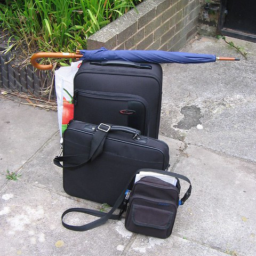

A blue and silver motorcycle is parked in a parking lot.


In [64]:
img = coco.loadImgs(testIds[np.random.randint(0,len(testIds))])[0]
image = io.imread(img['flickr_url'])
image = Image.fromarray(image)
image = resize(image)
image = normalize(np.asarray(image))
caption = model.predict(image.unsqueeze(0))
make_pic(image)
print(caption_to_string(caption))